In [2]:
import pandas as pd
import os
%matplotlib inline  

In [3]:
def makeLoadDoc():
    if os.path.isfile('./data/df_doc'):
        df = pd.read_pickle('./data/df_doc')
        return df
    else:
        pass

In [4]:
#df = makeLoadDoc()

In [5]:
#df = pd.DataFrame({'sentences': sentences})

In [6]:
df = pd.read_json('./data/dfExoplanetsNASAdetected100rand_v2.json', orient = 'table')
df = df[['sent', 'label']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 2 columns):
sent     100 non-null object
label    100 non-null object
dtypes: object(2)
memory usage: 2.3+ KB


In [8]:
df.columns

Index(['sent', 'label'], dtype='object')

In [9]:
df['category_id'] = df['label'].factorize()[0]
from io import StringIO
category_id_df = df[['sent', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sent', 'label']].values)

In [10]:
df.head()

,sent,label,category_id
0,We detected visual companions within 1'' for 5...,discovery,0
1,Using these data and photometry from the Spitz...,discovery,0
2,"Of the over 800 exoplanets detected to date, o...",None,1
3,We find that for these false positive scenario...,discovery,0
4,We present two exoplanets detected at Keck Obs...,discovery,0


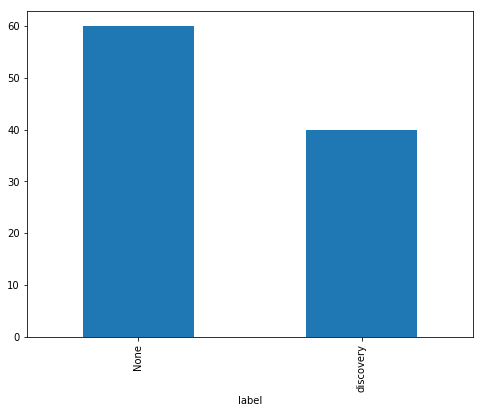

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').sent.count().plot.bar(ylim=0)
plt.show()

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.sent).toarray()
labels = np.array(df.category_id.astype(float))
features.shape

(100, 44)

In [30]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'A considerable change in Blazhko effect for V25 has been detected.':
  . Most correlated unigrams:
       . planets
       . dwarf
  . Most correlated bigrams:
       . planets detected
       . radial velocity
# 'A distinct supersoft X-ray component was also detected at optical maximum, which probably arises from an optically thick boundary layer.':
  . Most correlated unigrams:
       . planets
       . dwarf
  . Most correlated bigrams:
       . planets detected
       . radial velocity
# 'A solution to both of these problems is to use the science camera of an ExAO system as a wavefront sensor to perform a fast measurement and correction method to remove these aberrations as soon as they are detected.':
  . Most correlated unigrams:
       . planets
       . dwarf
  . Most correlated bigrams:
       . planets detected
       . radial velocity
# 'A variety of terrestrial planets with different physical parameters and exotic atmospheres might plausibly exist outside our Solar Syste

In [31]:
feature_names

array(['lines', 'events', 'microlensing', 'space', 'kepler', 'transit',
       'star', 'features', 'orbital', 'companions', 'earth', 'au',
       'orbiting', 'hd', 'based', 'observations', 'data', 'exoplanet',
       'planetary', 'present', 'stellar', '10', 'ground', 'systems',
       'stars', 'measurements', 'signal', 'using', 'high', 'mass',
       'velocity', 'telescope', 'planet', 'method', 'candidates',
       'exoplanets', 'radial', 'near', 'planets detected', 'detected',
       'emission', 'radial velocity', 'planets', 'dwarf'], dtype='<U16')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['sent'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [33]:
print(clf.predict(count_vect.transform([df.sent[0]])))

['discovery']


In [34]:
print(clf.predict(count_vect.transform([df.sent[20]])))

['None']


In [35]:
df[df['sent'] == df.sent[0]]

,sent,label,category_id
0,We detected visual companions within 1'' for 5...,discovery,0


In [36]:
df[df['sent'] == df.sent[20]]

,sent,label,category_id
20,The structures detected at millimeter waveleng...,None,1


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

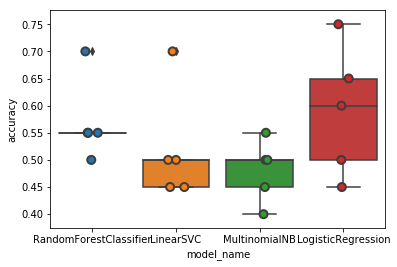

In [38]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [39]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.52
LogisticRegression        0.59
MultinomialNB             0.48
RandomForestClassifier    0.57
Name: accuracy, dtype: float64

In [40]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

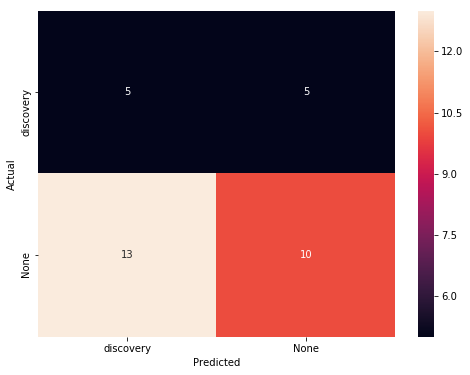

In [41]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(set(category_id_df.label.values)), yticklabels=list(set(category_id_df.label.values)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'sent']])
            print('')

AttributeError: 'DataFrame' object has no attribute 'category_id'

In [43]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [47]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [45]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."


KeyError: 1.0

In [46]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['label'].unique()))

              precision    recall  f1-score   support

   discovery       0.28      0.50      0.36        10
        None       0.67      0.43      0.53        23

   micro avg       0.45      0.45      0.45        33
   macro avg       0.47      0.47      0.44        33
weighted avg       0.55      0.45      0.48        33

